In [1]:
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip install JPype1
!pip install konlpy
!JAVA_HOME="C:\Program Files\Java\jdk-19"


Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [947 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [2]:
import konlpy

from konlpy.tag import Okt

from konlpy.utils import pprint

okt = Okt()

# 새 섹션

In [3]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.4 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3167624 sha256=44823a65e4d89a87eb59632d303adaf2ec333ff3a9191d23c9d99c215a8952b5
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [4]:

import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [5]:
from konlpy.tag import *
import fasttext
import pandas as pd
import re
from tqdm import tqdm_notebook
import numpy as np
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
from konlpy.tag import Okt
okt = Okt()


데이터셋 불러오기

자료는 공공 데이터 포탈에서 참고했습니다.

https://www.data.go.kr/data/15086437/fileData.do



In [7]:
import pandas as pd

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
df_corona = pd.read_csv('/content/drive/MyDrive/Section4 Project/corona.csv')
df_culture = pd.read_csv('/content/drive/MyDrive/Section4 Project/culture.csv', encoding='cp949')
df_fake = pd.read_csv('/content/drive/MyDrive/Section4 Project/fake_news.csv')

In [32]:
df_corona.head()

,주소,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건_사고 분류1,사건_사고 분류2,사건_사고 분류3,개체명(인물),개체명(지역),개체명(기업기관),키워드,특성추출,본문,원본주소
0,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,박재찬,폭염에 올 여름 전력수요 사상 최고치 전망...삐끗하면 `정전` 우려,경제>자원,경제>유통,경제>자동차,NaN,NaN,NaN,NaN,"경기, 고성하이화력, 부산, 태양광","국무총리, 산업부, 산업통상자원부, 전력거래소, 정부","폭염,전망,여름,전력,수요,사상,최고,정전,올여름,폭염,영향,산업,생산,증가,전기수...","여름철,올여름,산업부,전력수요,gw,예비력,대책기간,상한전망,발전기,전력판매량,최고...",올여름 폭염과 산업생산 증가 영향으로 전기수요가 역대 최고치를 기록할 것이라는 전망...,http://www.dt.co.kr/contents.html?article_no=2...
1,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,은진,상반기 수출 3000억달러 돌파…반도체·친환경 날개 달고 올해 `역대급` 실적 전망,경제>무역,경제>유통,경제>증권_증시,NaN,NaN,NaN,문승욱,"미국, 아세안, 인도, 일본, 중국, 중남미, 중동","CIS, EU, KOTRA, 무역협회, 산업부, 산업연구원, 산업통상자원부, 석유화...","3000억,상반기,수출,달러,돌파,반도체,친환경,날개,역대급,실적,전망,수출,상반기...","반도체,상반기,수출액,친환경,3000억,원자재,기저효과,우리나라,경신",올해 상반기 우리나라 수출이 누적 기준 사상 처음으로 3000억달러를 돌파했다......,http://www.dt.co.kr/contents.html?article_no=2...
2,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,강민성,"나라빚 1000조인데, 채무상환 고작 2조…전문가들 재정정상화 생색내기",경제>경제일반,NaN,NaN,NaN,NaN,NaN,"박영범, 신세돈, 홍남기",NaN,"경제학과, 국가재정법, 기획재정부, 숙명여대, 정부, 한성대","나라빚,채무상환,2조,전문가들,재정정상화,정부,초과,세수,예상,세계,잉여금,기금재원...","국가채무,2조,1000조,전문가,33조,채무상환,전문가들,본예산,한성대,홍남기,숙명...","정부가 올해 초과 세수 예상분 31조5000억원에 세계 잉여금, 기금재원까지 끌어모...",http://www.dt.co.kr/contents.html?article_no=2...
3,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,강민성,국세청 신임 차장에 임광현,지역>경남,지역>대구,지역>대전,NaN,NaN,NaN,"김재철, 김창기, 임광현, 임성빈","경북, 봉화, 장흥, 전남, 충남, 홍성","국세청, 부산지방국세청, 부산청장, 서울지방국세청, 서울지방국세청장, 서울청, 중부...","차장,국세청,신임,임광현,임광현,서울지방,국세청장,차장,국세청,임명,서울,청장,자리...","국세청,서울지방국세청,임성빈,임광현,국세청장,부산,납세자,서울지방,서울지방국세청장,...",임광현 서울지방국세청장이 차기 국세청 차장으로 임명됐다... 서울청장 자리에는 임성...,http://www.dt.co.kr/contents.html?article_no=2...
4,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,강민성,국세청 차장에 임광현…서울청장에 임성빈,지역>경남,지역>대구,지역>대전,NaN,NaN,NaN,"김재철, 김창기, 임광현, 임광현…서울청장, 임성빈","경북, 봉화, 장흥, 전남, 충남, 홍성","국세청, 부산지방국세청, 부산청장, 서울지방국세청, 서울지방국세청장, 서울청, 중부...","국세청,차장,임광현,서울청장,임성빈,국세청,인사,고위,정기,임광현,서울지방,국세청장...","국세청,임성빈,서울지방국세청,임광현,국세청장,부산,납세자,서울청장,서울지방,서울지방...",임광현 서울지방국세청장이 차기 국세청 차장으로 임명됐다... 서울청장 자리에는 임성...,http://www.dt.co.kr/contents.html?article_no=2...


In [33]:
df_corona['label']= 0
df_culture['label']=0
df_fake['label']=1

df_1 = pd.concat([df_corona, df_culture])
df = pd.concat([df_1,df_fake])
df

,주소,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건_사고 분류1,사건_사고 분류2,사건_사고 분류3,개체명(인물),개체명(지역),개체명(기업기관),키워드,특성추출,본문,원본주소,label
0,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,박재찬,폭염에 올 여름 전력수요 사상 최고치 전망...삐끗하면 `정전` 우려,경제>자원,경제>유통,경제>자동차,NaN,NaN,NaN,NaN,"경기, 고성하이화력, 부산, 태양광","국무총리, 산업부, 산업통상자원부, 전력거래소, 정부","폭염,전망,여름,전력,수요,사상,최고,정전,올여름,폭염,영향,산업,생산,증가,전기수...","여름철,올여름,산업부,전력수요,gw,예비력,대책기간,상한전망,발전기,전력판매량,최고...",올여름 폭염과 산업생산 증가 영향으로 전기수요가 역대 최고치를 기록할 것이라는 전망...,http://www.dt.co.kr/contents.html?article_no=2...,0
1,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,은진,상반기 수출 3000억달러 돌파…반도체·친환경 날개 달고 올해 `역대급` 실적 전망,경제>무역,경제>유통,경제>증권_증시,NaN,NaN,NaN,문승욱,"미국, 아세안, 인도, 일본, 중국, 중남미, 중동","CIS, EU, KOTRA, 무역협회, 산업부, 산업연구원, 산업통상자원부, 석유화...","3000억,상반기,수출,달러,돌파,반도체,친환경,날개,역대급,실적,전망,수출,상반기...","반도체,상반기,수출액,친환경,3000억,원자재,기저효과,우리나라,경신",올해 상반기 우리나라 수출이 누적 기준 사상 처음으로 3000억달러를 돌파했다......,http://www.dt.co.kr/contents.html?article_no=2...,0
2,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,강민성,"나라빚 1000조인데, 채무상환 고작 2조…전문가들 재정정상화 생색내기",경제>경제일반,NaN,NaN,NaN,NaN,NaN,"박영범, 신세돈, 홍남기",NaN,"경제학과, 국가재정법, 기획재정부, 숙명여대, 정부, 한성대","나라빚,채무상환,2조,전문가들,재정정상화,정부,초과,세수,예상,세계,잉여금,기금재원...","국가채무,2조,1000조,전문가,33조,채무상환,전문가들,본예산,한성대,홍남기,숙명...","정부가 올해 초과 세수 예상분 31조5000억원에 세계 잉여금, 기금재원까지 끌어모...",http://www.dt.co.kr/contents.html?article_no=2...,0
3,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,강민성,국세청 신임 차장에 임광현,지역>경남,지역>대구,지역>대전,NaN,NaN,NaN,"김재철, 김창기, 임광현, 임성빈","경북, 봉화, 장흥, 전남, 충남, 홍성","국세청, 부산지방국세청, 부산청장, 서울지방국세청, 서울지방국세청장, 서울청, 중부...","차장,국세청,신임,임광현,임광현,서울지방,국세청장,차장,국세청,임명,서울,청장,자리...","국세청,서울지방국세청,임성빈,임광현,국세청장,부산,납세자,서울지방,서울지방국세청장,...",임광현 서울지방국세청장이 차기 국세청 차장으로 임명됐다... 서울청장 자리에는 임성...,http://www.dt.co.kr/contents.html?article_no=2...,0
4,http://www.bigkinds.or.kr/news/newsDetailView....,2021-07-01,디지털타임스,강민성,국세청 차장에 임광현…서울청장에 임성빈,지역>경남,지역>대구,지역>대전,NaN,NaN,NaN,"김재철, 김창기, 임광현, 임광현…서울청장, 임성빈","경북, 봉화, 장흥, 전남, 충남, 홍성","국세청, 부산지방국세청, 부산청장, 서울지방국세청, 서울지방국세청장, 서울청, 중부...","국세청,차장,임광현,서울청장,임성빈,국세청,인사,고위,정기,임광현,서울지방,국세청장...","국세청,임성빈,서울지방국세청,임광현,국세청장,부산,납세자,서울청장,서울지방,서울지방...",임광현 서울지방국세청장이 차기 국세청 차장으로 임명됐다... 서울청장 자리에는 임성...,http://www.dt.co.kr/contents.html?article_no=2...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15906,http://www.bigkinds.or.kr/news/newsDetailView....,2020-12-31,한국경제,김소연,"[연예 마켓+] 유승준, 김형석과 손절 해명…'슈퍼챗'에 중간광고까지 수익 얼마",사회>미디어,NaN,NaN,범죄>범죄일반>사기,사회>사회문제>학대,사회>사회갈등>시위,"김형석, 문준용, 유승준, 조국, 문재인, 추미애","미국, 원도","정부, 유튜브, 미군 장갑차, 법무부, 한국, 소셜블레이드, #모종화병무청장, MBC","유승준,김형석,손절,해명,슈퍼챗,중간광고,수익,얼마,유승준,미국명,스티븐유,작심,발...","유승준,법무부,유튜브,슈퍼챗,문재인,추미애,그동안,실시간,1만,조회수,구독자,똥파리...",유승준(미국명 스티븐유)의 작심한 정부 비판 발언은 또 유튜브 수익으로 터질까......,https://www.hankyung.com/life/article/20201231...,1
15907,http://www.bigkinds.or.kr/news/newsDetailView....,2020-12-31,국민일보,이난초,말레이 ‘가짜 할랄 고기’ 스캔들…“고위공무원 연루”,문화>문화일반,국제>미국_북미,국제>중남미,NaN,NaN,NaN,NaN,"캐나다, 스페인, 항만, 말레이시아, 브라질, 볼리비아, 진위, 말레이, 콜롬비아","세관, 소고기, 뉴스트레이츠타임스, 이슬람, 정부, 종교부, 이슬람교도, 이슬람식,...","말레이,가짜,고기,스캔들,고위공무원,연루,말레이시아,40년,가짜,할랄,이슬람교도,무...","할랄,무슬림,말레이시아,공무원들,공무원,취급점,수입고기,캐나다,볼리비아,콜롬비아,자...",말레이시아에 40년 이상 가짜 할랄(이슬람교도인 무슬림이 먹고 쓸 수 있는 제품) ...,http://news.kmib.co.kr/article/view.asp?arcid=...,1
15908,http://www.bigkinds.or.kr/news/newsDetailView....,2020-12-31,한국경제,NaN,'다름'을 끌어안는 흰 소의 해…국민 지키는 최고 백신은 '상생 협력',NaN,NaN,NaN,범죄>정치>뇌물수수,범죄>범죄일반>방화,사고>산업사고>화재,"문재인, 문","신금, 화개, 서울, 민주, 부산, 소한, 당하, 남북","노벨상, 보궐선거, 경찰, 학원사, 창성, 동양, 신금, 정부, 유튜브, 대한민국,...","국민,최고,백신,상생,협력,신축,辛丑,천간,天干,오행,색깔,흰색,표상,불교,수행,깨...","신축년,편인,천간,축토,코로나19,신금,반도체,임기응변,배은망덕,경금,규괘,천재지변...",2021년 신축(辛丑)년은 흰 소의 해다... 천간(天干)인 신(辛)이 오행으로 금...,https://www.hankyung.com/life/article/20201231...,1
15909,http://www.bigkinds.or.kr/news/newsDetailView....,2020-12-31,매일경제,"윤원섭,서동철,진영태,전경운,문재용",Rebuild Korea…통합이 경쟁력이다,정치>국회_정당,정치>청와대,NaN,NaN,NaN,NaN,"강남규, 강동수, 강성진, 강주현, 강호갑, 권광석, 권태신, 길태기, 김기문, 김...","Korea, 경영혁신중기협회장, 곽노성, 대한민국, 독일경제포럼, 부산, 스웨덴, ...","EY한영, KAIST, KB국민은행, KDI, OECD, 가톨릭대, 강원대, 건국대...","Re

In [34]:
df_test = df[['제목','본문', 'label']]

필요한 데이터만 뽑아내기 및 불용어 처리는 뒷 파트에서 하겠습니다.



데이터 TF_IDF 사용하여 유사도 확인

In [70]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import spacy
from spacy.tokenizer import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

결측치 제거

In [14]:
df_test = df_test.dropna()

# 거짓 뉴스와 진짜 뉴스 기사의 분석

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
df_test['본문'].nunique(), df_test['label'].nunique()

(156470, 2)

In [37]:
train_data, test_data = train_test_split(df_test, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 122293
테스트용 리뷰의 개수 : 40765


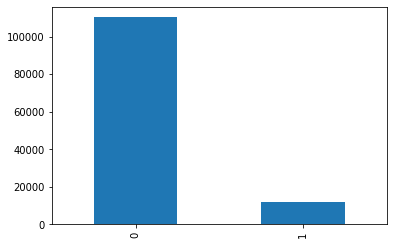

In [38]:
train_data['label'].value_counts().plot(kind = 'bar')

In [49]:
train_data['본문'] = train_data['본문'].str.replace("[^ ㄱ-ㅣ가-힣A-Za-z]","", )
train_data['본문'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data =train_data.dropna(how='any')
train_data['본문']= train_data['본문'].astype(str)

제목       71
본문       82
label     0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [57]:
train_data['제목'] = train_data['제목'].str.replace("[^ ㄱ-ㅣ가-힣A-Za-z]","", )
train_data['제목'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data =train_data.dropna(how='any')
train_data['제목']= train_data['제목'].astype(str)

test_data['제목'] = test_data['제목'].str.replace("[^ ㄱ-ㅣ가-힣A-Za-z]","", )
test_data['제목'].replace('', np.nan, inplace=True)
print(test_data.isnull().sum())
test_data =test_data.dropna(how='any')
test_data['제목']= test_data['제목'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


제목       0
본문       0
label    0
dtype: int64
제목       182
본문        18
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


불용어 정의

불용어 목록은 한 사이트를 참고하여 들고왔습니다. 

In [54]:
def get_stopwords():
    stopwords = list()
    
    f = open('/content/drive/MyDrive/Section4 Project/stopwords.txt', 'r', encoding='utf-8')
    
    while True:
        line = f.readline()
        if not line: break
        stopwords.append(line.strip())
        
    return stopwords

In [55]:


def okt_tokenizer(text):
    okt = Okt()
    text = re.sub(r'[^ ㄱ-ㅣ가-힣A-Za-z]', '', text) # 특수기호 제거
    stopwords = get_stopwords() # 불용어
    
    return [token for token in okt.nouns(text)
            if len(token) > 1 and token not in stopwords]

In [ ]:
stopwords = get_stopwords()
hannanum = Hannanum()
train_data['tokenized'] = train_data['본문'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['본문'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [58]:
stopwords = get_stopwords()
hannanum = Hannanum()
train_data['tokenized'] = train_data['제목'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['제목'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [62]:
true_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
fake_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [63]:
fake_word_count = Counter(fake_words)
print(fake_word_count.most_common(20))

[('가짜', 2360), ('코로나', 2296), ('뉴스', 2278), ('트럼프', 874), ('한', 816), ('은', 801), ('는', 665), ('도', 634), ('신종', 553), ('대통령', 539), ('적', 516), ('명', 456), ('대응', 426), ('서', 418), ('확', 381), ('당', 369), ('만', 369), ('경찰', 368), ('진자', 358), ('정부', 334)]


In [64]:
true_word_count = Counter(true_words)
print(true_word_count.most_common(20))

[('코로나', 9217), ('명', 8488), ('한', 4802), ('문화', 4702), ('도', 4346), ('서', 4030), ('확진', 3630), ('백신', 3482), ('대', 3329), ('은', 3276), ('확', 3175), ('진자', 2621), ('만', 2617), ('접종', 2533), ('한국', 2500), ('시', 2500), ('회', 2499), ('는', 2467), ('방역', 2344), ('전', 2179)]


# 해당 기사에 대한 분석 확인

In [71]:
tfidf = TfidfVectorizer(max_features=300, tokenizer= okt_tokenizer)

가짜 뉴스의 평균 길이 : 9.390040106951872
진짜 뉴스의 평균 길이 : 7.976179627840858


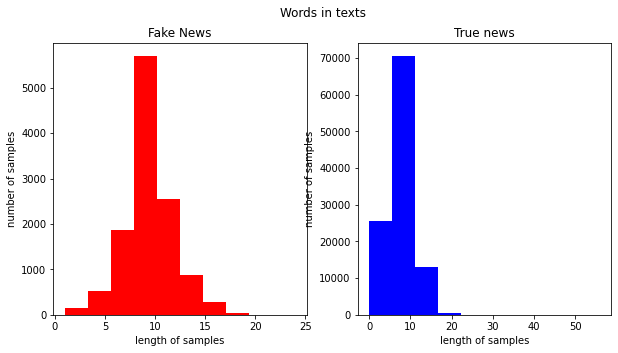

In [65]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Fake News')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('가짜 뉴스의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('True news')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('진짜 뉴스의 평균 길이 :', np.mean(text_len))
plt.show()

In [66]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [72]:
tdm = tfidf.fit_transform(df_test['본문'])

KeyboardInterrupt: ignored

In [ ]:
word_count = pd.DataFrame({
    '단어':  CountVectorizer.get_feature_names(),
    'tf-idf': tdm.sum(axis=0).flat
})

In [ ]:
word_count.sort_values('tf-idf', ascending=False).head(5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score
X_train, X_test, y_train, y_test = train_test_split(
    df_test, df_test['label'], test_size=0.2, random_state= 42)

# 모델 구현(Bi-LSTM)

In [ ]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))

# 그것을 바탕으로 분석한 결과로 결론 도출

결론을 내기 앞서 이것보다 짧은 기사 제목을 이용하여 LSTM 방식으로 어떤 것이 

# 참고 자료

knoply 관련 참고자료 : https://konlpy.org/_/downloads/en/latest/pdf/

한국어 전처리 과정 : https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html